<a href="https://colab.research.google.com/github/smart-stats/ds4bio_book/blob/main/book/explainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/smart-stats/ds4bio_book/HEAD)

## Explainability

Explainability is an important aspect for building trust in a neural network. If you can't explain why your algorithm performs as it does, then at the very least there is concern for overfitting, or fitting on irrelevant features having and association with the outcome. Below we'll show a very basic version of explainability. Let's redo our convnet example, now on the GPU. 


In [1]:
import urllib.request
import PIL
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

imgURL = "https://raw.githubusercontent.com/larvalabs/cryptopunks/master/punks.png"
urllib.request.urlretrieve(imgURL, "cryptoPunksAll.jpg")
img = PIL.Image.open("cryptoPunksAll.jpg").convert("RGB")
imgArray = np.asarray(img)

finalArray = np.empty((10000, 3, 24, 24))
for i in range(100):
  for j in range(100):
    a, b = 24 * i, 24 * (i + 1)  
    c, d = 24 * j, 24 * (j + 1) 
    idx = j + i * (100)
    finalArray[idx,0,:,:] = imgArray[a:b,c:d,0]
    finalArray[idx,1,:,:] = imgArray[a:b,c:d,1]
    finalArray[idx,2,:,:] = imgArray[a:b,c:d,2]

baseUrl = "https://raw.githubusercontent.com/cryptopunksnotdead/punks.attributes/master/original/"
for i in range(0,10000, 1000):
  url = baseUrl+str(i)+"-"+str(i + 999)+".csv"
  print(url)
  if (i == 0):
    dat = pd.read_csv(url)
  else :
    dat = pd.concat ([dat, pd.read_csv(url)], 
                      join = 'inner',
                     ignore_index = True)
    

dat = dat.assign(earring = dat[' accessories'].str.contains('Earring').astype(float).to_list())


https://raw.githubusercontent.com/cryptopunksnotdead/punks.attributes/master/original/0-999.csv
https://raw.githubusercontent.com/cryptopunksnotdead/punks.attributes/master/original/1000-1999.csv
https://raw.githubusercontent.com/cryptopunksnotdead/punks.attributes/master/original/2000-2999.csv
https://raw.githubusercontent.com/cryptopunksnotdead/punks.attributes/master/original/3000-3999.csv
https://raw.githubusercontent.com/cryptopunksnotdead/punks.attributes/master/original/4000-4999.csv
https://raw.githubusercontent.com/cryptopunksnotdead/punks.attributes/master/original/5000-5999.csv
https://raw.githubusercontent.com/cryptopunksnotdead/punks.attributes/master/original/6000-6999.csv
https://raw.githubusercontent.com/cryptopunksnotdead/punks.attributes/master/original/7000-7999.csv
https://raw.githubusercontent.com/cryptopunksnotdead/punks.attributes/master/original/8000-8999.csv
https://raw.githubusercontent.com/cryptopunksnotdead/punks.attributes/master/original/9000-9999.csv


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else :
    device = torch.device("cpu")

n = finalArray.shape[0]
trainFraction = .75
sample = np.random.uniform(size = n) < trainFraction
x_train = finalArray[ sample, :, :, :] / 255
x_test =  finalArray[~sample, :, :, :] / 255
    
y_train = dat.earring[sample].to_numpy()
y_test =  dat.earring[~sample].to_numpy()
## Need to have the extra dimension
y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

y_train = torch.Tensor(y_train).to(device)
x_train = torch.Tensor(x_train).to(device)
trainDataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
trainloader = torch.utils.data.DataLoader(trainDataset, batch_size = 100, shuffle = False, num_workers = 1)



In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 3 * 3, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x
net = Net().to(device)
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [4]:
for epoch in range(100):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

Here's the subject with the highest probability of having an earring. Let's save that subject and see what the algorithm finds so compelling about this subject.

([], <a list of 0 Text major ticklabel objects>)

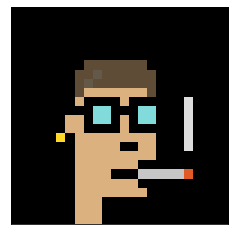

In [57]:
yhat = outputs.to( torch.device("cpu") ).detach().numpy()
## Grab the image that most likely has an earring
idx = np.argmax(yhat)
image = inputs.to( torch.device("cpu")).detach().numpy()[idx, :, :, :]
plt.imshow( np.transpose(image , (1, 2, 0)) )
plt.xticks([])
plt.yticks([])

Let's take the image and, one pixel at a time, zero it out. Then that pixel's won't propigate through the network. Let's then take that image and feed it through the network. If that pixel was very important, then the prediction would drop. If it wasn't very important, the prediction would stay the same. 

To elaborate, let $I1$ be the one with the highest probability of having an earring. Then set $I2 = I1$ except $I2[i,j] = 0$ for some fixed $i$ and $j$. Let $P$ be an array of the same size and set $P[i,j] = \phi(I2)$ where $\phi$ is our convolutional network. Pixels where $P$ is low means the prediction dropped after the removal of that pixel.

Let's try this out on this subject.

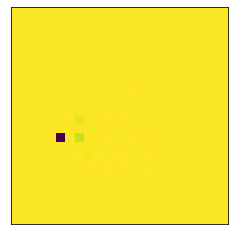

In [85]:
xdim = image.shape[1]
ydim = image.shape[2]
probmap = np.empty([xdim, ydim])
net.to(torch.device("cpu"))
for i in range(xdim):
  for j in range(ydim):
    temp = image.copy()
    temp[0, i, j] = 0
    temp[1, i, j] = 0
    temp[2, i, j] = 0
    ## add an extra row
    temp = temp[np.newaxis, :, :, :]
    probmap[i,j] = net(torch.tensor(temp))
probmap.shape
plt.imshow( probmap );
plt.xticks([]);
plt.yticks([]);


Notice that the probability that this subject has an earing plummets when we remove the pixel exactly where the earring is at.  This is a good sign that our algorithm is doing something appropriate.